# iGraph - Task 2

In [1]:
from igraph import Graph

from IPython import display
from igraph import plot
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

### Reading and displaying the graph

Reading data from the file by splitting each line into two nodes and add to de graph as undirected

In [2]:
edges = []
with open('edges.txt', 'r') as f:
    for e in f.readlines():
        v1, v2 = e.split(' ')
        edges.append((int(v1), int(v2)))
g = Graph(edges, directed=False)

Now let's extract the attributes of the graph, such as it's size, diameter and transitivity

In [3]:
directed = 'Directed' if g.is_directed() else 'Undirected'
num_vertices = len(g.vs)
num_edges = len(g.es)
diameter = g.diameter()
transitivity = g.transitivity_undirected()

print(f'The graph <V, E> is {directed}, with |V| = {num_vertices}, |E| = {num_edges},\
 d = {diameter} and transitivity = {transitivity}')

The graph <V, E> is Undirected, with |V| = 62, |E| = 602, d = 2 and transitivity = 0.5227690047741461


We encountered some problems while trying to display the degree distribution with the iGraph built-in function, so we will create our own histogram with Matplotlib and the degrees information:


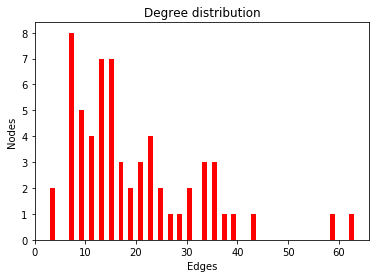

In [4]:
# Error plotting with iGraph: https://github.com/igraph/python-igraph/issues/88
# plot(g.degree_distribution())

h = g.degree()
plt.hist(h, bins=len(h), color='red')
plt.title('Degree distribution')
plt.xlabel('Edges')
plt.ylabel('Nodes')

plt.savefig('images/task2/hist_degree_distribution.png', dpi=200)

Let's take a look on how the graph looks:

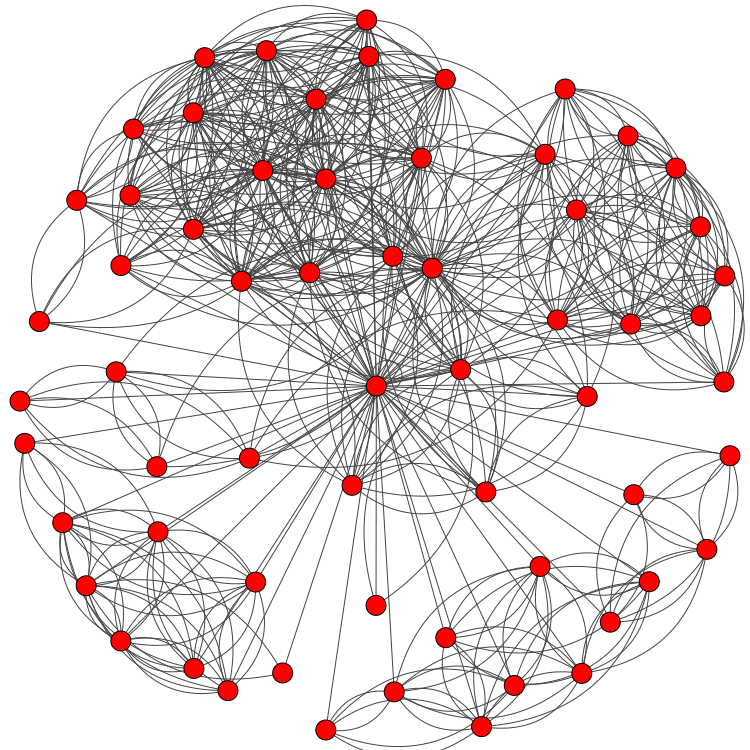

In [5]:
plot(g, layout = g.layout_kamada_kawai(),target='./images/task2/graph.png', bbox=(750, 750), margin=20)
display.Image(filename='./images/task2/graph.png')

It doesn't look like a random network as we can see well-defined and easily differentiable groups or clusters. There is a "central" node connected with most of the others.

Let's now check it better scaling the node sizes to its pagerank, by scaling the data and printing the pagerank corresponding to each node:

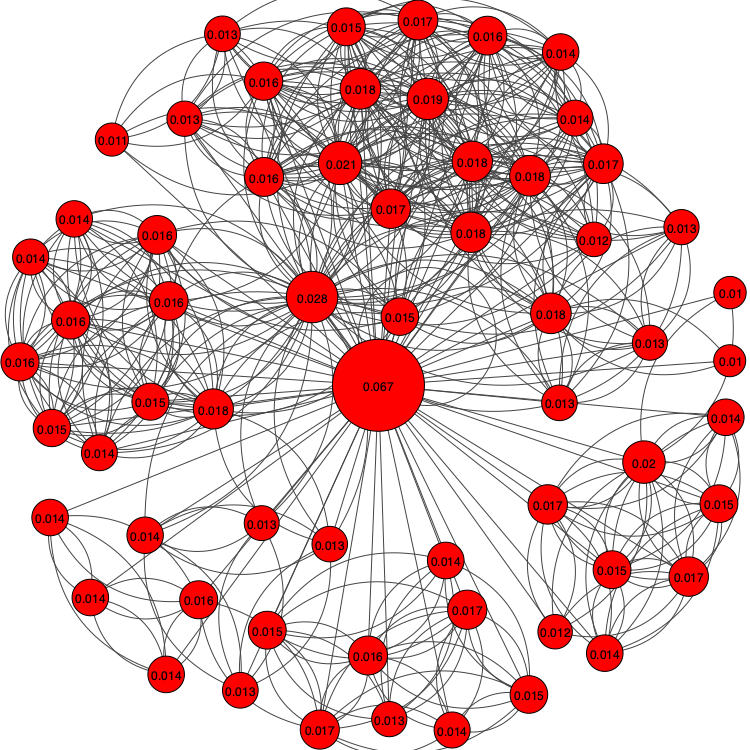

In [6]:
min_size = 32
max_size = 92
lab_size = 12
dec_size = 3

sc = MinMaxScaler(feature_range=(min_size, max_size))

pr = g.pagerank()
sc_pr = sc.fit_transform(np.array(pr).reshape(-1, 1))

gpr = g.copy()
gpr.vs['label_size'] = lab_size
for i in range(gpr.vcount()):
    gpr.vs[i]['size'] = sc_pr[i]
    gpr.vs[i]['label'] = round(pr[i], dec_size)

r = plot(gpr, layout=gpr.layout_kamada_kawai(), target='./images/task2/graph_pagerank.png', bbox=(750, 750))
display.Image(filename='./images/task2/graph_pagerank.png')

### Community Detection

In [7]:
def plot_community_histogram(clusters, name):
    sizes = clusters.sizes()
    
    plt.xlabel('Community size')
    plt.ylabel('# Communities')
    plt.hist(sizes, bins=range(min(sizes), max(sizes) + 2, 1), align='left')
    
    plt.savefig(f'./images/task2/{name}.png', dpi=200)
    print(clusters)

#### community_label_propagation

Finds the communities according to the label propagation method. Each vertex is assigned a different label. After that, each vertex chooses the dominant label in its neighbourhood in each iteration. Ties are broken randomly and the order in which the vertices are updated is randomized before every iteration. The algorithm ends when vertices reach a consensus. Note that since ties are broken randomly, there is no guarantee that the algorithm returns the same community structure after each run. In fact, they frequently differ.

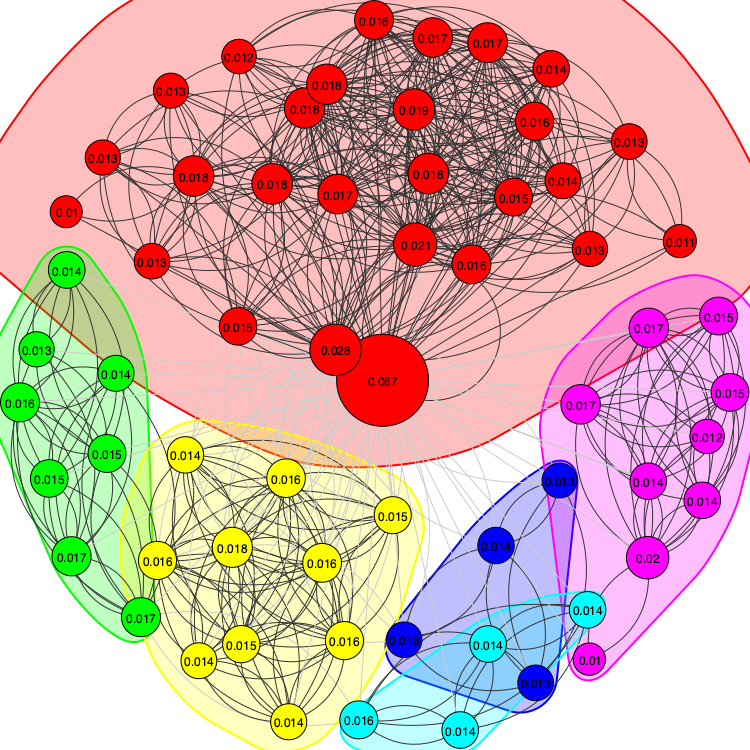

In [8]:
clusters_label_propagation = gpr.community_label_propagation()
r = plot(clusters_label_propagation, target='./images/task2/caimlab-clust-label-propagation.png', mark_groups=True, bbox=(750, 750))
display.Image(filename='./images/task2/caimlab-clust-label-propagation.png')

Clustering with 62 elements and 6 clusters
[0] 0, 3, 4, 7, 8, 12, 13, 16, 17, 18, 19, 23, 24, 30, 32, 33, 34, 39, 40, 42,
    43, 44, 46, 50, 58, 59, 60
[1] 1, 2, 26, 27, 38, 41, 56, 57
[2] 5, 6, 29, 49
[3] 9, 14, 15, 28, 31, 36, 47, 48, 53, 55
[4] 10, 11, 22, 25, 35, 37, 45, 51, 54
[5] 20, 21, 52, 61


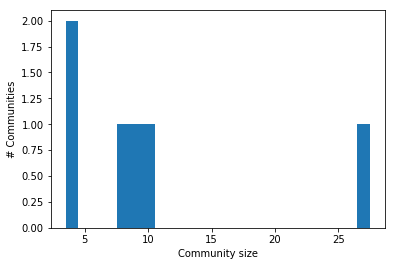

In [9]:
plot_community_histogram(clusters_label_propagation, 'hist_clusters_label_propagation')

#### community_leading_eigenvector

Finds communities using the leading eigenvector method, as described by Newman. It consider the problem of community detection approaching it as the maximization of the benefit function known as "modularity" over possible divisions of networks. Newman's paper shows that this maximization process can be written and implemented in terms of egenspectrum of a matrix called the modularity matrix, which plays a similar role as the graph Laplacian in graph partitioning. Different possible implementations are shown on Newman's paper which igraph documentation refers (but it doesn't specify which one is implemented), but all have the same behaviour: divide the network in two, and apply the algorithm again to its new parts separately.
Also the approach chosen for the "community_leading_eigenvector_naive" is simplier, but the function is only valid to separate the network into two communities and fails when trying to separate the network into more communities.

###### Reference: MEJ Newman: Finding community structure in networks using the eigenvectors of matrices, arXiv:physics/0605087

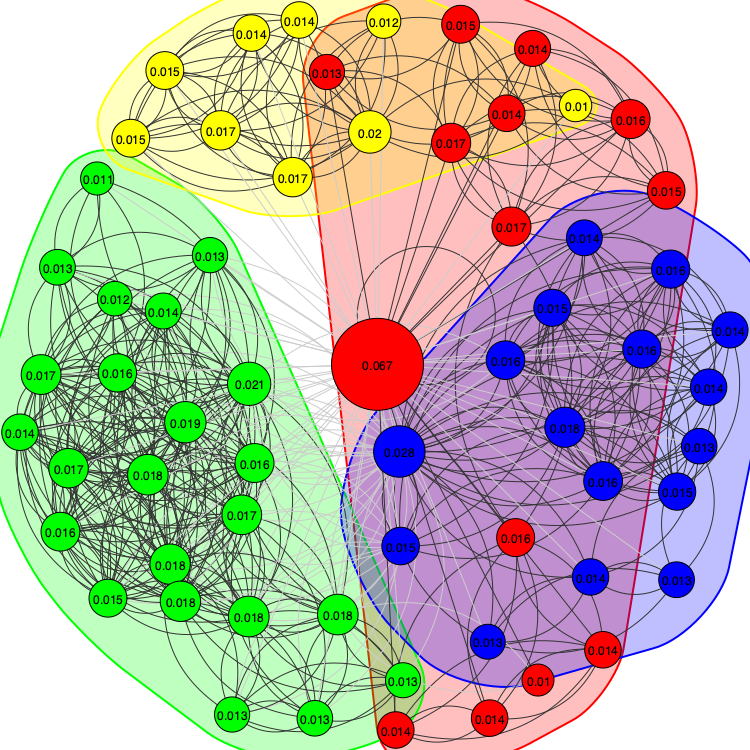

In [10]:
clusters_leading_eigenvector = gpr.community_leading_eigenvector()
r = plot(clusters_leading_eigenvector, target='./images/task2/caimlab-clust-leading-eigenvector.png', mark_groups=True, bbox=(750, 750))
display.Image(filename='./images/task2/caimlab-clust-leading-eigenvector.png')

Clustering with 62 elements and 4 clusters
[0] 0, 1, 2, 20, 21, 26, 27, 38, 41, 52, 56, 57, 60, 61
[1] 3, 4, 8, 12, 13, 16, 17, 18, 19, 23, 24, 30, 32, 33, 34, 39, 40, 43, 44,
    46, 50, 58, 59
[2] 5, 6, 7, 9, 14, 15, 28, 29, 31, 36, 42, 47, 48, 49, 53, 55
[3] 10, 11, 22, 25, 35, 37, 45, 51, 54


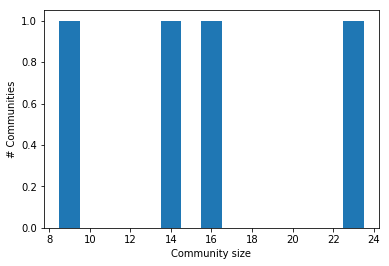

In [11]:
plot_community_histogram(clusters_leading_eigenvector, 'hist_clusters_leading_eigenvector')

#### community_infomap

Finds the community structure of the network according to the Infomap method of Martin Rosvall and Carl T. Bergstrom. It is used to reveal community structure in weighted and directed networks (which can explain the funny results obtained, since we are not using a directed or weighted graph). It decomposes a network into modules by optimally compressing a description of information flows on the network, resulting a map that simplifies and highlits regularities in the structure and relationships in the network.
Maybe using pagerank as weights in the graph we could see a result with more sense.

###### Reference: https://www.pnas.org/content/105/4/1118


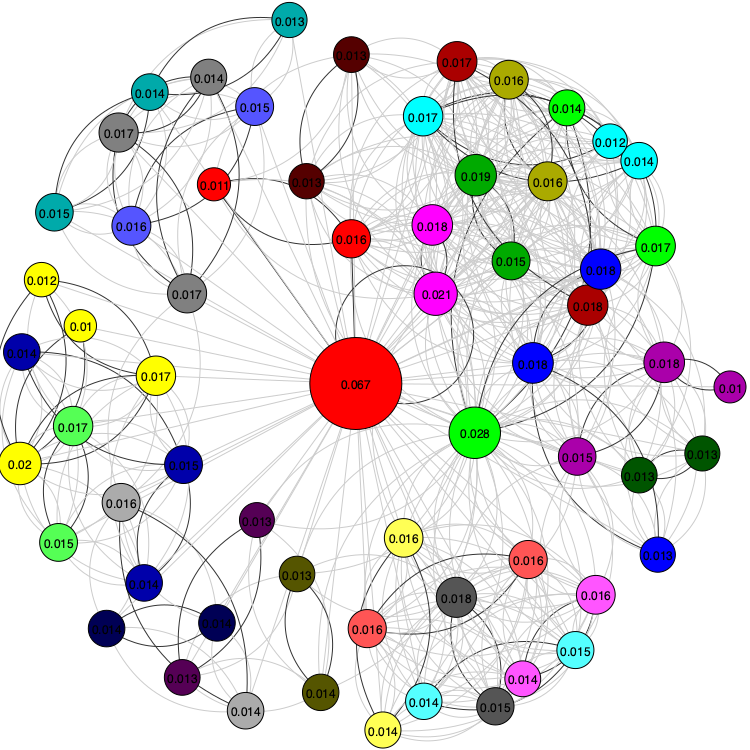

In [12]:
clusters_infomap = gpr.community_infomap()
r = plot(clusters_infomap, target='./images/task2/caimlab-clust-infomap.png', bbox=(750, 750))
display.Image(filename='./images/task2/caimlab-clust-infomap.png')

Clustering with 62 elements and 26 clusters
[ 0] 0, 16, 17
[ 1] 7, 33, 40
[ 2] 23, 30, 39
[ 3] 25, 35, 51, 54
[ 4] 24, 44
[ 5] 12, 18, 46
[ 6] 2, 26, 27
[ 7] 4, 19
[ 8] 3, 43
[ 9] 11, 22, 37
[10] 13, 34
[11] 32, 42, 60
[12] 38, 56, 57
[13] 9, 53
[14] 15, 36
[15] 10, 45
[16] 1, 41
[17] 47, 48
[18] 31, 55
[19] 14, 28
[20] 21, 61
[21] 58, 59
[22] 8, 50
[23] 20, 52
[24] 6, 29
[25] 5, 49


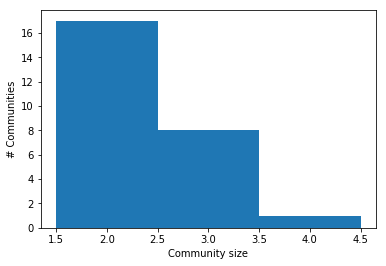

In [13]:
plot_community_histogram(clusters_infomap, 'hist_clusters_infomap')

#### community_multilevel

Initially each vertex belongs to separate communities, then are moved iteratively maximizing local contribution to the overall modularity score. It keeps going until consensus is reached (any move increases the modularity score), then each community behaves as a new vertex and we repeat the process. The algorithm stops when modularity score can't improve after shrinking the communities to vertices.

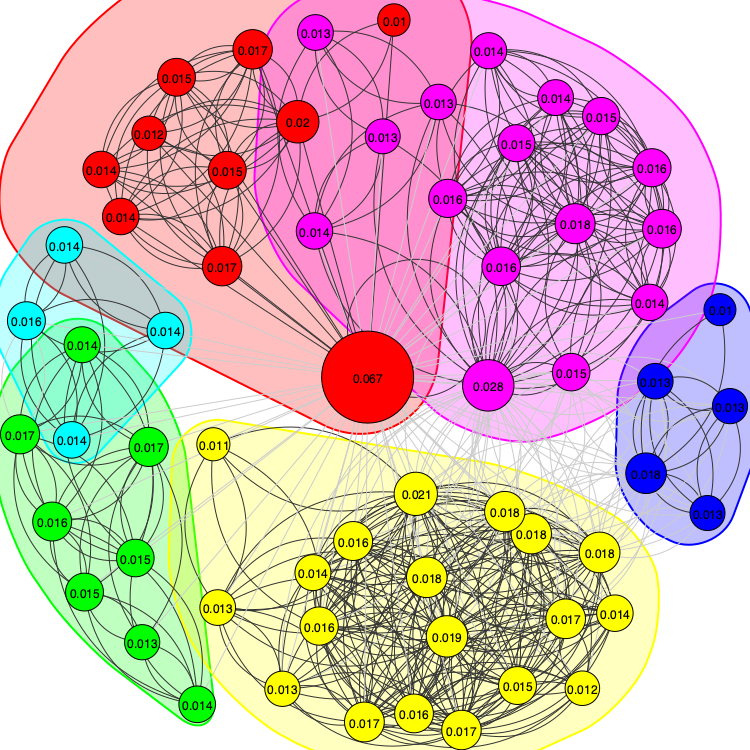

In [14]:
clusters_multilevel = gpr.community_multilevel()
r = plot(clusters_multilevel, target='./images/task2/caimlab-clust-multilevel.png', mark_groups=True, bbox=(750, 750))
display.Image(filename='./images/task2/caimlab-clust-multilevel.png')

Clustering with 62 elements and 6 clusters
[0] 0, 10, 11, 22, 25, 35, 37, 45, 51, 54
[1] 1, 2, 26, 27, 38, 41, 56, 57
[2] 8, 32, 39, 50, 60
[3] 3, 4, 12, 13, 16, 17, 18, 19, 23, 24, 30, 33, 34, 40, 43, 44, 46, 58, 59
[4] 5, 6, 7, 9, 14, 15, 28, 29, 31, 36, 42, 47, 48, 49, 53, 55
[5] 20, 21, 52, 61


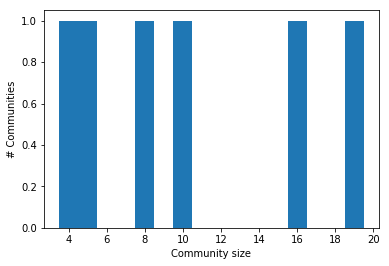

In [15]:
plot_community_histogram(clusters_multilevel, 'hist_clusters_multilevel')

#### community_optimal_modularity

This function uses the GNU Linear Programming Kit to solve a large integer optimization problem in order to find the optimal modularity score and the corresponding community structure.

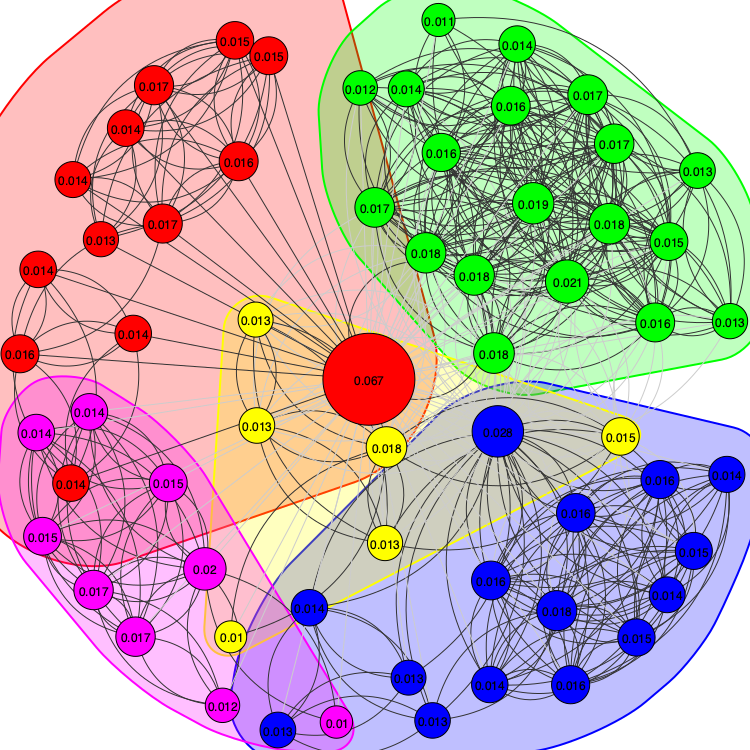

In [16]:
clusters_optimal_modularity = gpr.community_optimal_modularity()
r = plot(clusters_optimal_modularity, target='./images/task2/caimlab-clust-optimal-modularity.png', mark_groups=True, bbox=(750, 750))
display.Image(filename='./images/task2/caimlab-clust-optimal-modularity.png')

Clustering with 62 elements and 5 clusters
[0] 0, 1, 2, 20, 21, 26, 27, 38, 41, 52, 56, 57, 61
[1] 3, 4, 12, 13, 16, 17, 18, 19, 23, 24, 30, 33, 34, 40, 43, 44, 46, 58, 59
[2] 5, 6, 7, 9, 14, 15, 28, 29, 31, 36, 47, 48, 49, 53, 55
[3] 8, 32, 39, 42, 50, 60
[4] 10, 11, 22, 25, 35, 37, 45, 51, 54


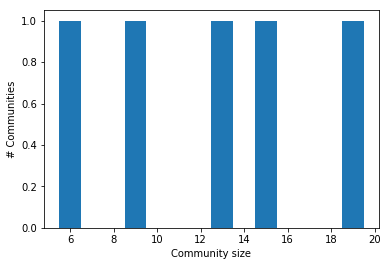

In [17]:
plot_community_histogram(clusters_optimal_modularity, 'hist_clusters_optimal_modularity')